<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/AIMango/AIMango.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect GoogleColab

In [ ]:
# 如果出現了長條型的可輸入單元格 代表你曾經 授權過了 可以直接跳到下一格
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
# 指定Google Drive雲端硬盤的根目錄，名為drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
os.chdir("drive")
if("Colab Notebooks" in os.listdir()):
  os.chdir("Colab Notebooks")
else:
  os.mkdir("Colab Notebooks")
  os.chdir("Colab Notebooks")

## 一、載入相關套件

In [ ]:
# 資料處理套件
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 設定顯示中文字體
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

In [ ]:
# Keras深度學習模組套件
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras import utils as np_utils
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In [ ]:
# tensorflow深度學習模組套件
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [ ]:
# 打印相關版本
print(pd.__version__)
print(tf.__version__)

1.0.3
2.2.0


In [ ]:
# 查看通道位置
print(K.image_data_format())

channels_last


In [ ]:
!pwd
! ls /content/drive/AIMango
! ln -fs /content/drive/AIMango /app

/content/drive/Colab Notebooks
'AI CUP 教育部全國大專校院人工智慧競賽-圖像辨識概念課教材_20200402.pdf'
 AIMango.ipynb
 sample_image
 Sample_Label.csv
 Sample_SurveyLabel.csv
 test_image


## 二、讀取資料

In [ ]:
# 讀取資料集標籤檔
Sample_label = pd.read_csv("/app/Sample_Label.csv",encoding="utf8")

In [ ]:
# 顯示資料集標籤檔
Sample_label.head()

,D-Plant2_0610_3.jpg,等級B
0,D-Plant2_0610_30.jpg,等級C
1,D-Plant2_0610_300.jpg,等級B
2,D-Plant2_0610_301.jpg,等級B
3,D-Plant2_0610_302.jpg,等級B
4,D-Plant2_0610_306.jpg,等級B


In [ ]:
# 串接圖片檔的路徑
Sample_pics_path = os.path.join("/app/sample_image")

In [ ]:
# 讀取路徑中的圖片
train_mango_fnames = os.listdir(Sample_pics_path)

In [ ]:
# 檢視是否有讀取到圖片
print(train_mango_fnames[0])
print(train_mango_fnames[1])
print(train_mango_fnames[2])

D-Plant2_0610_300.jpg
D-Plant2_0610_315.jpg
D-Plant2_0610_301.jpg


In [ ]:
# 用於瀏覽標籤檔的概況
label_Survey = pd.read_csv("/app/Sample_SurveyLabel.csv",encoding="utf8")

In [ ]:
label_Survey.head()

,Pics,Level
0,D-Plant2_0610_3.jpg,等級B
1,D-Plant2_0610_30.jpg,等級C
2,D-Plant2_0610_300.jpg,等級B
3,D-Plant2_0610_301.jpg,等級B
4,D-Plant2_0610_302.jpg,等級B


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31561 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32026 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31561 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32026 missing from current font.
  font.set_text(s, 0, flags=flags)


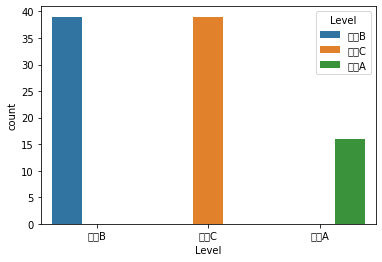

In [ ]:
sns.countplot(label_Survey['Level'], hue = label_Survey["Level"])

In [ ]:
sector = label_Survey.groupby('Level')
sector.size()

Level
等級A    16
等級B    39
等級C    39
dtype: int64

## 三、顯示芒果圖片

In [ ]:
# 讀取圖檔
img = mpimg.imread("/app/sample_image/D-Plant2_0610_39.jpg")
# 查看資料型態
type(img)

numpy.ndarray

In [ ]:
# 顯示圖片的比例
img.shape

(816, 1088, 3)

In [ ]:
# 把圖片的比例壓縮至800x800 
res = cv2.resize(img,(800,800),interpolation=cv2.INTER_LINEAR)

In [ ]:
# 顯示壓縮後圖片的比例
res.shape

(800, 800, 3)

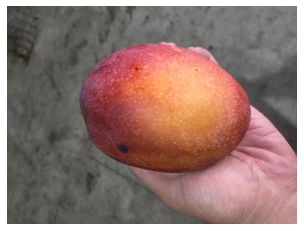

In [ ]:
# 顯示原圖的芒果照片
plt.imshow(img)
plt.axis('off')
plt.show()

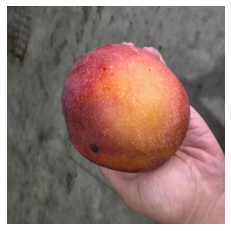

In [ ]:
# 顯示壓縮過原圖的芒果照片
plt.imshow(res)
plt.axis('off')
plt.show()

## 四、製作標籤&資料集

In [ ]:
csvfile = open('/app/Sample_Label.csv')
reader = csv.reader(csvfile)

In [ ]:
# 讀取csv標籤
labels = []
for line in reader:
    tmp = [line[0],line[1]]
    # print tmp
    labels.append(tmp)

csvfile.close() 

In [ ]:
picnum = len(labels)
print("芒果圖片數量: ",picnum)

芒果圖片數量:  94


In [ ]:
labels[8]

['D-Plant2_0610_31.jpg', '等級C']

In [ ]:
X = []
y = []

In [ ]:
# 轉換圖片的標籤
for i in range(len(labels)):
    labels[i][1] = labels[i][1].replace("等級A","0")
    labels[i][1] = labels[i][1].replace("等級B","1")
    labels[i][1] = labels[i][1].replace("等級C","2")

In [ ]:
# 隨機讀取圖片
a = 0
items= []

In [ ]:
import random
for a in range(0,94):
    items.append(a)

In [ ]:
# 製作訓練用資料集及標籤
for i in random.sample(items,94):
    img = cv2.imread("/app/sample_image/" + labels[i][0] )
    res = cv2.resize(img,(800,800),interpolation=cv2.INTER_LINEAR)
    res = img_to_array(res)
    X.append(res)    
    y.append(labels[i][1])

In [ ]:
y_label_org = y

In [ ]:
img[0]

array([[31, 27, 46],
       [30, 26, 45],
       [27, 25, 44],
       ...,
       [83, 97, 95],
       [82, 96, 94],
       [82, 96, 94]], dtype=uint8)

In [ ]:
print(len(X))
print(len(y))

94
94


In [ ]:
# 轉換至array的格式
X = np.array(X)
y = np.array(y)

In [ ]:
# 轉換至float的格式
for i in range(len(X)):
    X[i] = X[i].astype('float32')

In [ ]:
# 打映圖片訓練集的概況
# print(X[0])
print(type(X))
print(X.shape)

print(X[0].shape)
print(type(X[0]))

<class 'numpy.ndarray'>
(94, 800, 800, 3)
(800, 800, 3)
<class 'numpy.ndarray'>


In [ ]:
# 將標籤轉換至float格式
y = tf.strings.to_number(y, out_type=tf.float32)

In [ ]:
# 打映圖片標籤的概況
print(y[0])
print(type(y[0]))

tf.Tensor(2.0, shape=(), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
# 標籤進行one-hotencoding
y = np_utils.to_categorical(y, num_classes = 3)

In [ ]:
y[0]

array([0., 0., 1.], dtype=float32)

## 五、製作訓練資料集

In [ ]:
# 分配訓練集及測試集比例
x_train = X[:84]
y_train = y[:84]
x_test = X[84:]
y_test = y[84:]

In [ ]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y_train_label = [0.,0.,0.]

for i in range(0,len(y_train)):
    y_train_label = y_train[i] + y_train_label

In [ ]:
y_test_label = [0.,0.,0.]

for i in range(0,len(y_test)):
    y_test_label = y_train[i] + y_test_label

In [ ]:
y_train_label

array([13., 33., 38.])

In [ ]:
y_test_label

array([1., 4., 5.])

In [ ]:
print(type(x_train))
print(len(x_train))
print(x_train.shape)
print(type(x_train[0]))

<class 'numpy.ndarray'>
84
(84, 800, 800, 3)
<class 'numpy.ndarray'>


## 六、建立與訓練深度學習Model

In [ ]:
# 建立深度學習CNN Model

model = tf.keras.Sequential()

model.add(layers.Conv2D(16,(3,3),
                 strides=(1,1),
                 input_shape=(800, 800, 3),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(32,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Conv2D(64,(3,3),
                 strides=(1,1),
                 padding='same',
                 activation='relu',
                 ))

model.add(layers.MaxPooling2D(pool_size=(2,2),strides=None))

model.add(layers.Flatten())

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(128,activation='relu'))


model.add(layers.Dropout(0.2))

model.add(layers.Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 800, 800, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 800, 800, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 400, 400, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 400, 400, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 64)      0

history = model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
adam = optimizers.adam(lr=5)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])

In [ ]:
# zca_whitening 對輸入數據施加ZCA白化
# rotation_range 數據提升時圖片隨機轉動的角度
# width_shift_range 圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
# shear_range 剪切強度（逆時針方向的剪切變換角度）
# zoom_range 隨機縮放的幅度
# horizontal_flip 進行隨機水平翻轉
# fill_mode ‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理

datagen = ImageDataGenerator(
    zca_whitening=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# 導入圖像增強參數
datagen.fit(x_train)
x_train = x_train/255
x_test = x_test/255
print('rescale！done!')

rescale！done!


In [ ]:
# 設定超參數HyperParameters 
batch_size =  4
epochs = 10

In [ ]:
# 檔名設定
file_name = str(epochs)+'_'+str(batch_size)

In [ ]:
# 加入EarlyStopping以及Tensorboard等回調函數
CB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
TB = keras.callbacks.TensorBoard(log_dir='./log'+"_"+file_name, histogram_freq=1)

In [ ]:
history = model.fit(
    x = x_train , y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2,
    callbacks = [CB]
)

Epoch 1/10
17/17 [==============================] - 6s 343ms/step - loss: 9.9505 - acc: 0.3881 - val_loss: 1.0948 - val_acc: 0.2941
Epoch 2/10
17/17 [==============================] - 4s 216ms/step - loss: 0.8996 - acc: 0.5970 - val_loss: 1.0911 - val_acc: 0.2941
Epoch 3/10
17/17 [==============================] - 4s 214ms/step - loss: 0.5217 - acc: 0.7761 - val_loss: 1.0716 - val_acc: 0.2941
Epoch 4/10
17/17 [==============================] - 4s 214ms/step - loss: 0.5031 - acc: 0.8657 - val_loss: 1.0682 - val_acc: 0.2941
Epoch 5/10
17/17 [==============================] - 4s 214ms/step - loss: 0.2799 - acc: 0.8806 - val_loss: 1.0261 - val_acc: 0.5294
Epoch 6/10
17/17 [==============================] - 4s 215ms/step - loss: 0.1594 - acc: 0.9104 - val_loss: 0.9632 - val_acc: 0.4706
Epoch 7/10
17/17 [==============================] - 4s 214ms/step - loss: 0.1154 - acc: 0.9254 - val_loss: 0.8624 - val_acc: 0.7647
Epoch 8/10
17/17 [==============================] - 4s 215ms/step - loss: 0.

## 柒、繪製Model學習成效

In [ ]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

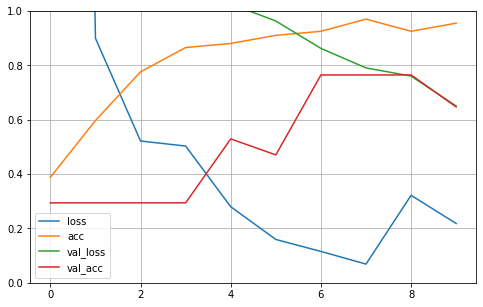

In [ ]:
plot_learning_curves(history)

## 捌、推測圖片

In [ ]:
test_mango_dir = os.path.join("/app/test_image")
test_mango_fnames = os.listdir(test_mango_dir)

In [ ]:
test_mango_fnames[0]

'00010.jpg'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


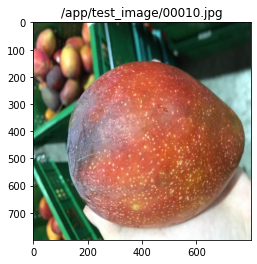

In [ ]:
img_files = [os.path.join(test_mango_dir,f) for f in test_mango_fnames]
img_path = random.choice(img_files)

# 讀入待測試圖像並秀出
img = load_img(img_path, target_size=(800, 800))  # this is a PIL image
plt.title(img_path)
plt.grid(False)
plt.imshow(img)

In [ ]:
labels = ['等級A','等級B',"等級C"]

In [ ]:
# 將圖像轉成模型可分析格式(800x800x3, float32)
x = img_to_array(img)  # Numpy array with shape (800, 800, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 800, 800, 3)
x /= 255 # Rescale by 1/255

start = time.time() # 啟動計時器
result = model.predict(x) # 對輸入圖像進行推論(預測)
finish = time.time() # 結束計時器

pred = result.argmax(axis=1)[0]
pred_prob = result[0][pred]

print("Result = %f" %pred_prob) # 印出結果可能機率值(0.0 ~ 1.0)
print("Test time :%f second." %(finish-start)) # 印出推論時間

# 設定分類門檻值並印出推論結果
print("有 {:.2f}% 機率為{}".format(pred_prob * 100,labels[pred])) # 印出推論時間

Result = 0.841549
Test time :0.195701 second.
有 84.15% 機率為等級B


## 玖、測試集預測準確度

In [ ]:
# 測試集標籤預測
y_pred = model.predict(x_test)

In [ ]:
# 整體準確度
count = 0
for i in range(len(y_pred)):
    if(np.argmax(y_pred[i]) == np.argmax(y_test[i])): #argmax函数找到最大值的索引，即为其类别
        count += 1
score = count/len(y_pred)
print('正确率为:%.2f%s' % (score*100,'%'))

正确率为:70.00%


In [ ]:
# 模型預測後的標籤
predict_label = np.argmax(y_pred,axis=1)
print(predict_label)
print(len(predict_label))

[1 0 1 1 1 1 1 0 2 1]
10


In [ ]:
# 模型原標籤
true_label = y_label_org[84:]
true_label = np.array(true_label)
print(true_label)
print(len(true_label))

['1' '0' '1' '1' '1' '0' '1' '0' '1' '2']
10


In [ ]:
# 模型預測後的標籤
predictions = model.predict_classes(x_test)
print(predictions)
print(len(predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[1 0 1 1 1 1 1 0 2 1]
10


In [ ]:
pd.crosstab(true_label,predict_label,rownames=['實際值'],colnames=['預測值'])

預測值,0,1,2
實際值,,,
0,2,1,0
1,0,5,1
2,0,1,0


In [ ]:
# 儲存模型相關參數
model.save('/app/'+file_name+'.h5')